In [28]:
%load_ext dotenv
%dotenv
import os
import psycopg2 as ps
import pandas as pd
from sqlalchemy import create_engine

conn_string = f'postgresql://{os.environ["USER"]}@{os.environ["HOST"]}:{os.environ["PORT"]}/{os.environ["DBNAME"]}'
db = create_engine(conn_string)
alchemy_conn = db.connect()

conn = ps.connect(
    host=os.environ['HOST'],
    port=os.environ['PORT'],
    dbname=os.environ['DBNAME'],
    user=os.environ['USER']
)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [2]:
df = pd.read_sql_query('select * from prod', con=conn)
df.head()

,datetime,mwh_del,nodeprice,hubprice,floatinbligationvolume
0,2021-06-01 00:15:00,5.538,19.13,19.10,22.00
1,2021-06-01 00:30:00,7.482,18.95,18.95,22.00
2,2021-06-01 00:45:00,4.560,19.77,18.88,22.00
3,2021-06-01 01:00:00,3.186,21.43,19.11,22.00
4,2021-06-01 01:15:00,4.717,22.00,19.27,21.75


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   datetime                2304 non-null   datetime64[ns]
 1   mwh_del                 2302 non-null   float64       
 2   nodeprice               2192 non-null   float64       
 3   hubprice                2304 non-null   float64       
 4   floatinbligationvolume  2304 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 90.1 KB


In [4]:
df.describe()

,mwh_del,nodeprice,hubprice,floatinbligationvolume
count,2302.000000,2192.000000,2304.000000,2304.000000
mean,14.949313,24.962901,25.857856,17.302083
std,12.167448,32.070873,30.960078,3.559052
min,0.000000,-1.520000,-1.520000,11.750000
25%,4.171750,18.050000,19.010000,13.812500
50%,12.067000,20.960000,21.825000,17.625000
75%,25.420750,28.562500,28.762500,20.312500
max,37.828000,701.030000,701.030000,22.750000


array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

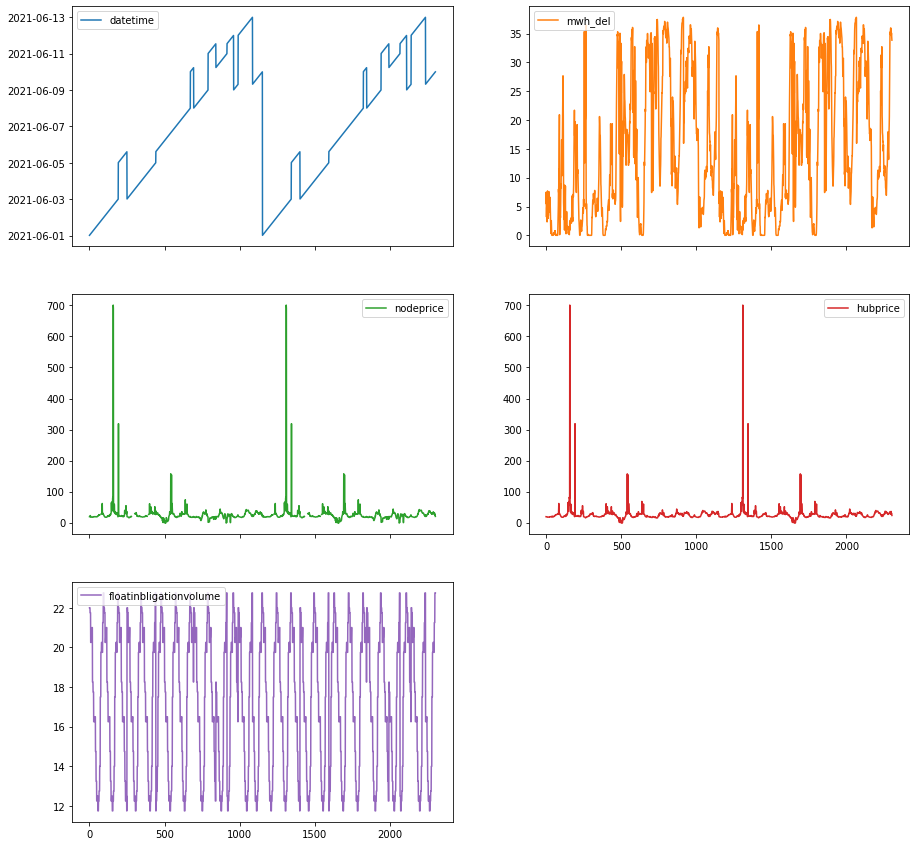

In [5]:
df.plot(subplots=True, layout=(3,2), figsize=(15,15))

In [6]:
# Less accurate transformation, because the revenue should be calculated with 
# multiplying the actual, not the mean price
#
# aggregated_df = df.resample('D', on='datetime').agg({
#     'mwh_del':'sum', 
#     'nodeprice':'mean',
#     'hubprice':'mean',
#     'floatinbligationvolume': 'sum'})
# 
# aggregated_df['FloatingObligation'] = aggregated_df['floatinbligationvolume'] * aggregated_df['hubprice']
# aggregated_df['MerchantRevenue'] = aggregated_df['mwh_del'] * aggregated_df['nodeprice']
# aggregated_df = aggregated_df.drop(columns=['floatinbligationvolume'])
# aggregated_df.rename(columns = {'mwh_del':'Production', 'nodeprice':'PowerPriceNode', 'hubprice': 'PowerPriceHub'}, inplace = True)
# aggregated_df.head()

In [25]:
aggregated_df = df.copy()
aggregated_df['FloatingObligation'] = aggregated_df['floatinbligationvolume'] * aggregated_df['hubprice']
aggregated_df['MerchantRevenue'] = aggregated_df['mwh_del'] * aggregated_df['nodeprice']

aggregated_df = aggregated_df.resample('D', on='datetime').agg({
    'mwh_del':'sum', 
    'nodeprice':'mean',
    'hubprice':'mean',
    'floatinbligationvolume': 'sum',
    'FloatingObligation' : 'sum',
    'MerchantRevenue': 'sum'})

aggregated_df = aggregated_df.drop(columns=['floatinbligationvolume'])
aggregated_df.rename(columns = {'mwh_del':'Production', 'nodeprice':'PowerPriceNode', 'hubprice': 'PowerPriceHub'}, inplace = True)
aggregated_df.head()

,Production,PowerPriceNode,PowerPriceHub,FloatingObligation,MerchantRevenue
datetime,,,,,
2021-06-01,560.358,22.397403,22.466737,74118.945,13488.15488
2021-06-02,1254.994,44.198854,44.198229,126294.475,33018.73128
2021-06-03,1261.116,20.964384,21.619792,69524.870,23892.71244
2021-06-04,1337.872,26.639412,26.347812,85408.330,34112.01852
2021-06-05,1844.950,28.142105,28.060729,93077.830,53172.07542


In [29]:
conn.autocommit = True
cur = conn.cursor()

cur.execute('''
CREATE TABLE daily(
	Datetime timestamp(3) NULL,
	"Production" double precision NULL,
	"PowerPriceNode" double precision NULL,
	"PowerPriceHub" double precision NULL,
	"FloatingObligation" double precision NULL,
	"MerchantRevenue" double precision NULL);
    ''')

aggregated_df.to_sql('daily', con=alchemy_conn, if_exists='append')
  
conn.close()

(datetime.datetime(2021, 6, 1, 0, 0), 560.358, 22.397402597402596, 22.466736842105266, 74118.945, 13488.15488)
(datetime.datetime(2021, 6, 2, 0, 0), 1254.994, 44.19885416666667, 44.198229166666664, 126294.475, 33018.73128)
(datetime.datetime(2021, 6, 3, 0, 0), 1261.116, 20.964383561643835, 21.619791666666668, 69524.87, 23892.71244)
(datetime.datetime(2021, 6, 4, 0, 0), 1337.872, 26.63941176470588, 26.3478125, 85408.33, 34112.01852)
(datetime.datetime(2021, 6, 5, 0, 0), 1844.95, 28.142105263157895, 28.060729166666665, 93077.83, 53172.07542)
(datetime.datetime(2021, 6, 6, 0, 0), 4129.642, 20.207604166666666, 21.117708333333333, 64519.39, 76997.86598)
(datetime.datetime(2021, 6, 7, 0, 0), 2313.046, 25.078064516129036, 24.604479166666668, 78679.21, 47634.63866)
(datetime.datetime(2021, 6, 8, 0, 0), 5002.8859999999995, 20.925104166666667, 21.859375, 72319.945, 97725.30726)
(datetime.datetime(2021, 6, 9, 0, 0), 4264.718, 26.06177083333333, 25.891041666666666, 83878.385, 103650.4485)
(datetim